## 3104538 Tiziano Paci - NLP Individual Project

The midterm project is designed to let you apply what you have learned so far, and demonstrate that you have mastered it. The submission will be graded on the correctness of the execution of your analysis (50%), the ambitiousness of the problems chosen (30%), and the creativity of your questions and solutions (20%).

Please note that the project is ***individual***, and the solutions will be checked for substantial overlap. However, you should feel free to discuss problems and ideas with your class mates, just do not share code.

Your submission should include all outputs and be **self-contained**, so it can be executed if necessary.


## Submission
The project is due on ***March 26 2021, 23:59 CET***. The time stamp of the email or upload determines the submission time. *Late submissions will NOT be considered, and graded as 0.*

Submitting the midterm means you will be counted as attending student, meaning the final project is a group project. You can not switch status after the midterm deadline.

To submit, please:

1. rename this file with your student ID
2. copy this file and all additional data into a folder with your student ID
3. zip the entire folder
4. send a copy of the zip file to Tommaso Fornaciari <fornaciari.tommaso@unibocconi.it>

For large files, you can use **wetransfer**. Please do not use Dropbox links, since they are not time-stamped!

## 1: Data and Preprocessing (5 pts)

**Exercise:** \
Pick a data set with **at least 5,000** documents that you have found yourself.
Briefly (max. 100 words!) describe the content and type of the data set (book, reviews, Twitter, ...). 

Preprocess the data and explain (max. 200 words) which preprocessing steps you chose and why, and give statistics of the number of documents, types, and tokens, before and after preprocessing.

I download and collect together the five books belonging to the non-technical bibliography of Nicholas Nassim Taleb, in particular:

-**"Fooled by Randomness"**, about the underestimation of the role of randomness in life; \
-**"The Black Swan"**, about unpredictable events; \
-**"The Bed of Procrustes: Philosophical and Practical Aphorisms"**, a collection of aphorisms; \
-**"Antifragile: Things That Gain from Disorder"**, which builds upon ideas from his previous works; \
-**"Skin in the Game: Hidden Asymmetries in Daily Life"**, explaining the reasons behind the need for having a measurable risk when taking a major decision.

In the preprocessing section I start by tokenizing words while keeping only the relevant parts of speech I am interested in. In addition, I keep on removing stopwords, capital letters and words with length shorter than 3 characters.\
After this basic steps I proceed with a very simple regular expression in order to definitely clean my tokens. Finally, I plot a graph representing the most frequent words after the above-mentioned steps. Spoiler: they will still be distributed according to the Zipf's law.

Please note that statistics and further comments are provided along the journey.

In [52]:
import pandas as pd
import numpy as np

import nltk
import spacy
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.collocations import *

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
import seaborn as sb
import matplotlib.cm as cm

from gensim.models import Word2Vec, Doc2Vec, LdaMulticore, TfidfModel, CoherenceModel, AuthorTopicModel
from gensim.models.word2vec import FAST_VERSION
from gensim.models.doc2vec import TaggedDocument
from gensim.corpora import Dictionary
from gensim.models.phrases import Phrases
from gensim.test.utils import datapath, temporary_file

from gensim.models import AuthorTopicModel
from gensim.test.utils import datapath, temporary_file

import time 
import multiprocessing
import string
import random
import re

In [3]:
documents_1 = [line.strip() for line in open('Fooled_by_randomness.txt', encoding='utf8').readlines()]
documents_2 = [line.strip() for line in open('The_Black_Swan.txt', encoding='utf8').readlines()]
documents_3 = [line.strip() for line in open('The_Bed_of_Procrustes.txt', encoding='utf8').readlines()]
documents_4 = [line.strip() for line in open('Antifragile_things_that_gain_from_disorder.txt', encoding='utf8').readlines()]
documents_5 = [line.strip() for line in open('Skin_in_the_game.txt', encoding='utf8').readlines()]

In [4]:
print(documents_1 [:5])
print()
print(documents_2 [:5])
print()
print(documents_3 [:5])
print()
print(documents_4 [:5])
print()
print(documents_5 [:5])

#Just by looking at the first print, I realize that some good preprocessing is required.

['Shrinking the World', 'I first met Robert Shiller in person as we were seated next to each', 'other at a breakfast panel discussion. I found myself inadvertently', 'eating all the fruits on his plate and drinking his coffee and water,', 'leaving him with the muffins and other unfashionable food (and']

['THE BLACK SWAN', '', '', '', '']

['PROCRUSTES', '', 'Procrustes, in Greek mythology, was the cruel owner of a small estate in Corydalus in Attica, on the way between Athens and Eleusis,', 'where the mystery rites were performed. Procrustes had a peculiar sense of hospitality: he abducted travelers, provided them with a', 'generous dinner, then invited them to spend the night in a rather special bed. He wanted the bed to t the traveler to perfection. Those']

['', 'I. HOW TO LOVE THE WIND', '', 'Wind extinguishes a candle and energizes fire.', 'Likewise with randomness, uncertainty, chaos: you want to use them, not']

['THE LESS OBVIOUS ASPECTS OF SKIN IN THE GAME', '', 'A more corre

After having imported the books, I collect them in a single list.

In [5]:
documents = [documents_1 + documents_2 + documents_3 + documents_4 + documents_5]
documents = list(pd.core.common.flatten(documents)) #I need a list and not a list of lists

In [6]:
len(documents)  #I have 43668 different documents, intended as lines of text, within my context before any sort of preprocessing 

43668

For what concerns the preprocessing investigation, in the following code I will explain and justify the different procedures undertaken.\
I begin to clean the text by taking tokens and not lemmas because, for the moment, inflectional endings may be important in reaching my scope, which I will explain in the next section. However, I remove words characterized by POS not included in the 'NOUN', 'VERB', 'ADJ', 'ADV', 'PROPN' categories.

In [7]:
nlp = spacy.load('en_core_web_sm')

tokens = [token.text for sentence in documents for token in nlp(sentence) if token.pos_ in ('NOUN', 'VERB', 'ADJ', 'ADV', 'PROPN')]

In [9]:
print('Length of tokens at this step:', len(tokens))
print()
print(Counter(tokens))

Length of tokens at this step: 245064

Counter({'be': 1847, 'more': 1753, 'have': 1313, 'people': 1270, 'is': 1054, 'when': 945, 'other': 786, 'so': 760, 'such': 715, 'time': 713, 'N': 682, 'even': 663, 'had': 652, 'how': 642, 'do': 639, 'very': 619, 'life': 611, 'only': 603, 'just': 597, 'S': 579, 'E': 549, 'same': 541, 'make': 531, 'see': 505, 'much': 502, 'T': 501, 'most': 499, 'called': 497, 'has': 491, 'get': 490, 'know': 480, 'are': 479, 'problem': 473, 'things': 460, 'I': 449, 'way': 446, 'small': 440, 'O': 438, 'many': 424, 'risk': 423, 'need': 416, 'world': 415, 'idea': 414, 'book': 413, 'large': 402, 'then': 401, 'So': 390, 'take': 378, 'too': 368, 'point': 365, 'M': 364, 'R': 356, 'randomness': 354, 'rather': 353, 'A': 352, 'less': 351, 'Black': 346, 'events': 343, 'others': 341, 'also': 336, 'never': 336, 'good': 336, 'where': 332, 'knowledge': 330, 'made': 330, 'business': 325, 'own': 324, 'effect': 323, 'few': 320, 'first': 318, 'years': 316, 'science': 315, 'work': 313, 

Next, I am going to remove the punctuation marks as they are not very useful for my purpose. I am going to use *isalpha( )* method to separate the punctuation marks from the actual text. Together with that, I also delete stopwords.

In [10]:
stopwords = stopwords.words("english")
words_no_punc = []

#Removing punctuation marks:
for w in tokens:
    if w.isalpha():
        words_no_punc.append(w.lower())

#Removing stopwords
clean_words = []

for w in words_no_punc:
    if w not in stopwords:
        clean_words.append(w)

In [12]:
print('The length of tokens is now:', len(clean_words))

#Almost half of the previous length, after removing stopwords and puctuation marks.

The length of tokens is now: 213731


However, I am not interested in any word with less than 3 characters

In [14]:
words = [x for x in clean_words if len(x) > 3]

print('The length of tokens is now:', len(words))

The length of tokens is now: 198979


Still, by looking at the 'words' counter, I see that some words end up with 'xad', probably due to a problem occurred when importing the datasets. Thus, I develop a small regex in order to remove those useless words

In [19]:
numbers = re.compile('[a-z]+\xad')

for i in range(len(words)):
    words[i]= re.sub(numbers, '0', words[i])
    words[i]= words[i].lower()           #also capital letters are removed
    
words = [x for x in words if len(x) > 3] #I run again the same function to remove the 0s I created

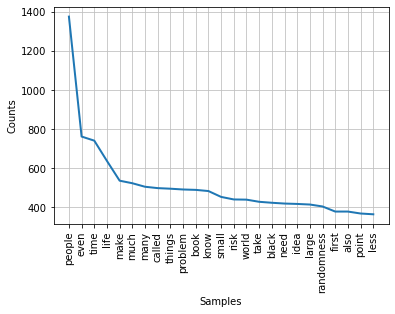

In [20]:
#Frequency distribution of the 25 most common useful words:
fdist = FreqDist(words)
fdist.plot(25)

#What can be noted here is that, even after the preprocessing steps, the distribution of words resembles a Zipf's one.

## 2 - 3: Analysis (15 pts) and Visualization (10 pts)

**Requirements:** \
Describe what question you are investigating with the data (max. 100 words) and provide visualizations for all of the analyses. Be creative. Just please do not use word clouds...


Use at least **five** of the following analysis methods to the data set (justify your choices and make them explicit):

* Word embeddings 
* Document embeddings
* TFIDF analysis
* Topic models
* Dimensionality reduction
* Clustering
* Language models

Justify your choice of the number of latent dimensions/topics/clusters!

Your analysis needs to be run on **at least 5,000** preprocessed documents!

If appropriate for your problem, feel free to explore other methods we discussed (NER, parsing, POS, etc.), or algorithms not covered in class (e.g., clustering algorithms, etc.), as long as they do not require additional libraries (up to 2 bonus points).

**ANALYSIS**: 


The main aim of my work is to characterize the way Nicholas Nassim Taleb refers to the concepts related to the world of **'randomness'**, under many different aspects. I read all of the five books I am going to employ as documents and I was fascinated by the way in which, always referring to different topics, the underlying message of his texts was inherently very much the same: how to cope with *unpredictability*. Therefore, I have considered this project as the perfect opportunity to further investigate the specificities of the vocabulary of an author I liked this much.

I start by proposing a **TFIDF analysis** to understand which are the most significant terms (and bigrams) in the context.
Subsequently, I proceed with word and document embeddings, by considering respectively **word2vec** and **doc2vec** algorithms. In this section I think some of the most interesting results show up. Clearly, I also provide a graphical representation which aims at characterizing the relevant affinities in the author's vocabulary. Then, I want in some sense to challenge my work with a **language model**; that is, I would like to understand whether and under which conditions the model is able to capture the  subjective (compared to the semantic) meaning Taleb attributes to some selected words.

Then, the topic model I propose is an **Author Topic Model** in that I find out that it works much better than the other options under investigation. Furthermore, I searched for some **latent topics** employing the **singular value decomposition (SVD)** algorithm. Finally, I illustrate a graphical tridimensional representation of a **k-means clustering** algorithm.


Also in this section, I will provide further details along the journey.

In [23]:
#INVESTIGATING COLLOCATIONS

bgm = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(words)

#After some investigation I concluded that trigrams are not that helpful for my purpose and therefore I exclude them from the notebook.

In [25]:
finder.apply_freq_filter(2)
finder.nbest(bgm.mi_like, 10)
#Some interesting bigrams are found and then employed for different purposes.

[('black', 'swan'),
 ('skin', 'game'),
 ('bell', 'curve'),
 ('monte', 'carlo'),
 ('black', 'swans'),
 ('united', 'states'),
 ('umberto', 'antilibrary'),
 ('yogi', 'berra'),
 ('trial', 'error'),
 ('vice', 'versa')]

In [26]:
score = bgm.mi_like
#For consistency with respect to the previous step I keep on using mi_like. I could have also used likelihood_ratio.

#I join collocations together and I retrieve their score.
collocations = {'_'.join(bigram): pmi for bigram, pmi in finder.score_ngrams(score)} 

Counter(collocations).most_common(20)

[('black_swan', 135.80567560579198),
 ('skin_game', 96.58380595341087),
 ('bell_curve', 63.91991846243448),
 ('monte_carlo', 48.0),
 ('black_swans', 30.455569461827285),
 ('united_states', 30.340557275541794),
 ('umberto_antilibrary', 20.507287449392713),
 ('yogi_berra', 12.5),
 ('trial_error', 11.192148365304952),
 ('vice_versa', 11.062903225806451),
 ('ralph_nader', 10.461904761904762),
 ('green_lumber', 9.340350877192982),
 ('adam_smith', 9.266968325791856),
 ('track_record', 8.927479772250525),
 ('federal_reserve', 8.631713554987213),
 ('umberto_antiubrary', 8.507076923076923),
 ('bertrand_russell', 7.363636363636363),
 ('saudi_arabia', 7.211538461538462),
 ('ludic_fallacy', 7.185964912280702),
 ('cherry_picking', 6.456470588235294)]

## **TFIDF** ANALYSIS

In [27]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word', strip_accents='unicode', lowercase=True, use_idf=True,
                                   ngram_range=(2,4), #up to now this is the range I need for relevant concepts
                                   min_df=0.0005, #for the purpose, this level of min_df is a good compromise between computational intensity and relevance
                                   max_df=0.5, 
                                   stop_words='english', 
                                   sublinear_tf=True)

X = tfidf_vectorizer.fit_transform(documents)

In [28]:
count_vectorizer = CountVectorizer(analyzer='word', strip_accents='unicode', lowercase=True,
                                   ngram_range=(2,4), min_df=0.0005, max_df=0.5, stop_words='english')

X_word = count_vectorizer.fit_transform(documents)

word_counts = X_word.toarray()
word_tfidf = X.toarray()

df_tfidf = pd.DataFrame(data = {'word': count_vectorizer.get_feature_names(),
                                'tf': word_counts.sum(axis = 0),
                                'idf': tfidf_vectorizer.idf_,
                                'tfidf': word_tfidf.sum(axis=0)})

df_tfidf = df_tfidf.sort_values(['tfidf','tf','idf'])

In [31]:
df_tfidf.head(60)

,word,tf,idf,tfidf
9,eco antiubrary,24,8.465518,14.384412
56,umberto eco antiubrary,24,8.465518,14.384412
35,new york city,33,8.158033,20.101977
62,york city,34,8.129046,21.030549
22,long run,23,8.548900,21.441301
14,gray swans extremistan,37,8.046808,21.450521
50,swans extremistan,37,8.046808,21.450521
15,green lumber,22,8.548900,21.580271
36,problem induction,22,8.548900,21.729272
8,eco antilibrary,37,8.046808,21.849956


Within this dataframe, some concepts appear to be much relevant in terms of tfidf. In particular, some bigrams are strongly related to the world of statistics and probability (i.e. bell curve, long time, decision making, etc.), some others to the psychology framework (ludic fallacy, narrative fallacy, etc.) and some on the Taleb-related meanings (black swans, fat tony, fooled randomness, etc.).

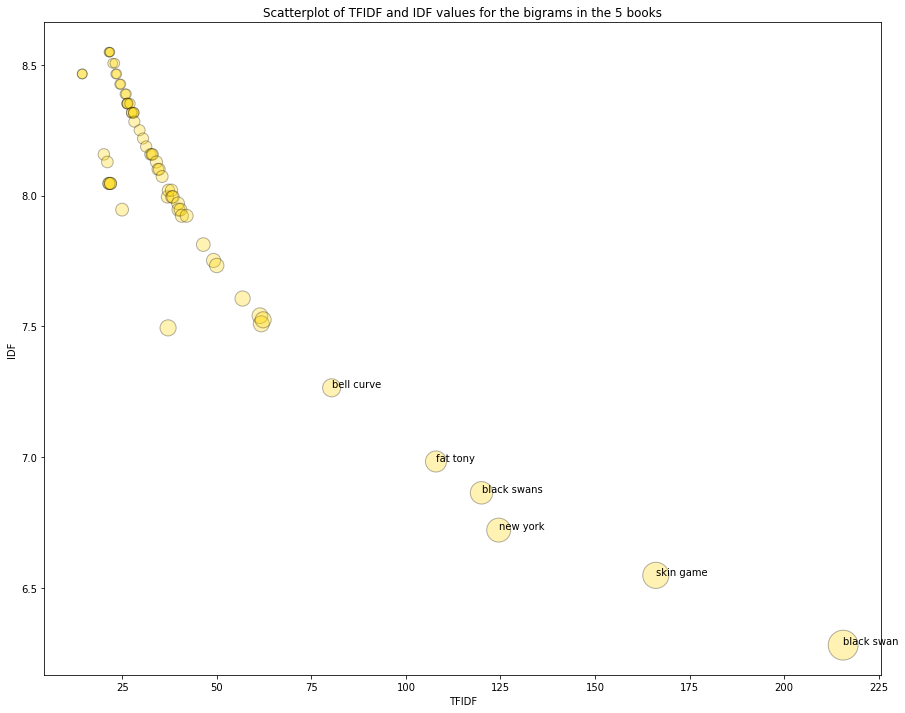

In [36]:
#df_tfidf['tf'] *= 4        #this may be useful the first time the graph is run.

w = []
plt.figure(figsize=(15,12))
plt.scatter(x = df_tfidf['tfidf'], y = df_tfidf['idf'], s = df_tfidf['tf'], alpha = 0.3, edgecolor = 'k', c = 'gold')

for label, x, y in zip(df_tfidf.iloc[-6:,0], df_tfidf.iloc[-6:,3], df_tfidf.iloc[-6:,2]):
    txt = plt.annotate(label, xy = (x, y), xytext=(x, y+0.002))
    w.append(label)
    
    plt.title('Scatterplot of TFIDF and IDF values for the bigrams in the 5 books') 
    #Why bigrams? They are much more interesting in my opinion.
    plt.xlabel('TFIDF')
    plt.ylabel('IDF')

## **WORD_2_VEC and SIMILARITY CONCEPTUALIZATION WITH T-SNE**

In [37]:
#Two minutes of time are required by this step
corpus_w2v = [document.split() for document in documents]
 
w2v_model = Word2Vec(size=100, # vector size, it works fine
                     window=18, 
                     sample=0.0001, # subsampling rate, it is a good compromise between reliability and computational issues
                     iter=1300, # iterations, final number of different trials
                     negative=5,
                     min_count=10, # minimum threshold; checking for relevance
                     workers=-1, 
                     hs=0, # no hierarchical softmax, I use a negative sampling
                     seed=42)

w2v_model.build_vocab(corpus_w2v)

w2v_model.train(corpus_w2v, total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)

#Note: this Word2Vec is trained on the whole set of documents, before the preprocessing steps.

(0, 0)

In [38]:
w2v_model.wv.most_similar('random')
#In the Taleb's view, many 'enterpreneurs' behave randomly and moreover 'random' is much correlated with 'probability'. These results appear to have sense.

[('acts', 0.4783463478088379),
 ('positive', 0.4106525182723999),
 ('Probability', 0.39964771270751953),
 ('investment', 0.3742244243621826),
 ('entrepreneurs', 0.34959694743156433),
 ('given', 0.2874484360218048),
 ('days,', 0.2837478518486023),
 ('effects.', 0.2795785367488861),
 ('say', 0.2766808867454529),
 ('her', 0.27339479327201843)]

In [39]:
w2v_model.wv.most_similar('antifragile')
#Being antifragile is typical for intellectuals. Moreover, the term refers to how a person deals with 'randomness'. Again, cool similarities.

[('built', 0.38282155990600586),
 ('developing', 0.3337112069129944),
 ('randomness;', 0.3300926387310028),
 ('million,', 0.3247166574001312),
 ('INTELLECTUAL', 0.31709811091423035),
 ('applying', 0.29231536388397217),
 ('form', 0.2866990864276886),
 ('acquire', 0.28019264340400696),
 ('modus', 0.2723575830459595),
 ('seemed', 0.2714320421218872)]

In [61]:
w2v_model.wv.most_similar(positive=['antifragile', 'rational'], negative=['randomness'], topn=3)

[('straight', 0.3787892460823059),
 ('returns', 0.34280163049697876),
 ('acquire', 0.33259791135787964)]

Quite interesting. If we 'sum' antifragile and rational, two strongly related concepts in Taleb's view, and we 'subtract' randomness, we are obtaining a 'straight' individual, which is likely to get 'returns' from investments. This result signals the way the author refers to the concept of being rational and antifragile when dealing with randomness. Probably, he would be happy to read this.

In [58]:
#Are some words similar in the context of Taleb's book but not in other frameworks? Let's discover it.
word1 = "antifragile"
word2 = "Mediocristan"
word3 = "randomness"
word4 = "scientist"

print('Similarity between antifragile and Mediocristan:', w2v_model.wv.similarity(word1, word2))
print('Similarity between randomness and Mediocristan:', w2v_model.wv.similarity(word3, word2))
print('Similarity between scientist and Mediocristan:', w2v_model.wv.similarity(word4, word2))

Similarity between antifragile and Mediocristan: 0.0067084134
Similarity between randomness and Mediocristan: 0.013091937
Similarity between scientist and Mediocristan: 0.21648125


Here it is very interesting to observe how Mediocristan, the average person without much capabilities in Taleb's view, is in no way connected with 'antifragile' and 'randomness'. A Mediocristan does not know these terms at all. 

In [42]:
#Trying to improve quality: excluding irrelevant words
#It takes some minutes (3 to 5) to run

included_tags = {"NOUN", "VERB", "ADJ", "ADV", "PROPN"}

clean_doc = []
for sentence in documents:
    new_sentence = []
    for token in nlp(sentence):
        if token.pos_  in included_tags:
            new_sentence.append(token.text.lower()+'_'+token.pos_)
    clean_doc.append(" ".join(new_sentence))

In [43]:
#It takes some minutes (2 to 4) to run
word_corpus = [[token.text for token in nlp(new_sentence)] for new_sentence in clean_doc]

In [44]:
w2v_model_ex = Word2Vec(size=100, window=18, sample=0.0001, iter=1300, negative=5, min_count=10, workers=-1, hs=0, seed = 42)
#For consistency and possibility of comparison I wanted to keep the same parameters I employed in the previous w2v model

w2v_model_ex.build_vocab(word_corpus)

w2v_model_ex.train(word_corpus, total_examples=w2v_model_ex.corpus_count, epochs=w2v_model_ex.epochs)

(0, 0)

In [45]:
w2v_model_ex.wv.most_similar('random_ADJ')

[('service_NOUN', 0.37417230010032654),
 ('unread_ADJ', 0.3606674075126648),
 ('tribe_NOUN', 0.2972753345966339),
 ('relief_NOUN', 0.273395836353302),
 ('stress_NOUN', 0.270091712474823),
 ('treadmill_NOUN', 0.2631186246871948),
 ('sophisticated_ADJ', 0.2617330551147461),
 ('disorder_NOUN', 0.2599036395549774),
 ('falls_VERB', 0.2576594352722168),
 ('specialize_VERB', 0.25071951746940613)]

It is quite impressive to observe how different are the most similar terms to 'random' when adding their relative POS and after having removed stopwords with respect to the pervious case. \
Again, in my opinion it makes much sense this result because the intrinsic meaning of the word 'random' is way different from the subjective meaning it takes in the author's books.

In [78]:
w2v_model_ex.wv.most_similar(positive=['antifragile_ADJ', 'rationality_NOUN'], negative=['randomness_NOUN'], topn=3)

#We can observe how the 'sum and difference' of the same concepts radically changes when POS are taken into consideration.

[('try_VERB', 0.3653883934020996),
 ('grandfather_NOUN', 0.3227085471153259),
 ('cousins_NOUN', 0.3042248487472534)]

In [59]:
word1_POS = "antifragile_ADJ"
word2_POS = "mediocristan_PROPN"
word3_POS = "randomness_NOUN"
word4_POS = "scientist_NOUN"

print('Similarity between antifragile_ADJ and mediocristan_PROPN:', w2v_model_ex.wv.similarity(word1_POS, word2_POS))
print('Similarity between randomness_NOUN and mediocristan_PROPN:', w2v_model_ex.wv.similarity(word3_POS, word2_POS))
print('Similarity between scientist_NOUN and mediocristan_PROPN:', w2v_model_ex.wv.similarity(word4_POS, word2_POS))

Similarity between antifragile_ADJ and mediocristan_PROPN: 0.12910071
Similarity between randomness_NOUN and mediocristan_PROPN: 0.030740999
Similarity between scientist_NOUN and mediocristan_PROPN: -0.014353458


Once again, with respect to the previous example, here we see that when we assign to the words the relative POS we tend to lose the subjective meaning that the author assigned to the word 'mediocristan'. In fact, it evidently increases its similarity with 'antifragile'. \
Please note that obviously I tried with different parameters and also by averaging across different embedding matrices.
Here I decide to present some of the interesting findings.

In [49]:
#I select 5 very relevant words in the context and I represent graphically their related concepts.

keys = ['antifragile', 'scientist', 'random', 'event', 'fallacy']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_model.most_similar(word, topn=8):
        words.append(similar_word)
        embeddings.append(w2v_model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

<ipython-input-49-b00f6dc6d8e9>:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  for similar_word, _ in w2v_model.most_similar(word, topn=8):
<ipython-input-49-b00f6dc6d8e9>:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embeddings.append(w2v_model[similar_word])


In [51]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model = TSNE(perplexity=15, n_components=2, init='pca', n_iter=15000, random_state=42)
#Random_state has been the same up to now, the number of interactions is chosen because it provides comfortable results

embeddings_2d = np.array(tsne_model.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

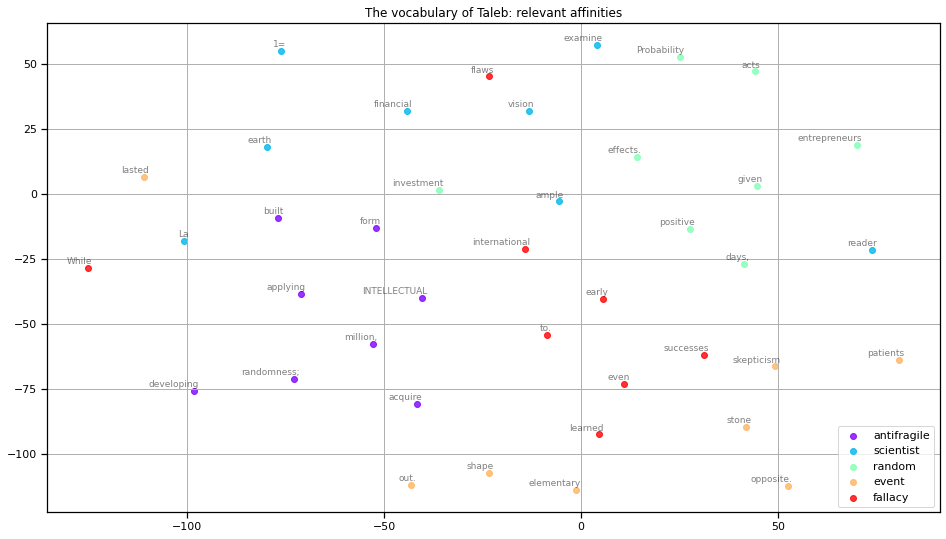

In [151]:
%matplotlib inline

def tsne_plot_sw(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=9)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_sw('The vocabulary of Taleb: relevant affinities', keys, embeddings_2d, word_clusters, 0.8)

I think some lines can be devoted to the explanation of this graphical representation. \
First of all, some interesting distinctions and groupings realize. Positive (as intended by Taleb) words are strongly related to the concept of 'antifragile' (e.g. intellectual) and a negative one (flaws) is similar to 'fallacy'.
Together with this, 'antifragile' related terms are in the opposite quadrant with respect to 'random' because, as you probably have learnt along this journey, being antifragile means contrasting random decisions and events in a rational way.


Another cool similarity is 'skepticism' which is in the yellow cluster. In fact, we need to be skeptical about 'events' in the author's view.


Finally, would you ever talk about a 'scientist' using a word as 'financial'? Probably not. Still, a scientist is someone who take financially sounding decisions and has a 'ample' 'vision'.

## **DOC_2_VEC**

In [79]:
#Grouping sentences per Book. How do Taleb's books differ in this 'phrases' dimension?

book_names = ['Fooled_by_randomness', 'The_Black_Swan', 'The_Bed_of_Procrustes', 'Antifragile_things_that_gain_from_disorder', 'Skin_in_the_game']
book_content = [documents_1, documents_2, documents_3, documents_4, documents_5]
index = []
for i in range (len(documents)):
    if i < len(documents_1):
        index.append(book_names[0])
    elif i < len(documents_1+documents_2):
        index.append(book_names[1])
    elif i < len(documents_1+documents_2+documents_3):
        index.append(book_names[2])
    elif i < len(documents_1+documents_2+documents_3+documents_4):
        index.append(book_names[3])
    else:
        index.append(book_names[4])

In [80]:
df_books = pd.DataFrame({'Book':index, 'Sentences':documents})

In [81]:
df_books.head()

,Book,Sentences
0,Fooled_by_randomness,Shrinking the World
1,Fooled_by_randomness,I first met Robert Shiller in person as we wer...
2,Fooled_by_randomness,other at a breakfast panel discussion. I found...
3,Fooled_by_randomness,eating all the fruits on his plate and drinkin...
4,Fooled_by_randomness,leaving him with the muffins and other unfashi...


In [82]:
corpus_d2v = []

for row in df_books.iterrows():
    label = row[1].Book
    text = row[1].Sentences
    corpus_d2v.append(TaggedDocument(words=text.split(), tags=[str(label)]))

In [104]:
#It takes around a minute and a half
d2v_model = Doc2Vec(vector_size=115, #almost the squareroot of my vocabulary length
                    window=15, #Sentences on average are not too long
                    hs=0, sample=0.000001, negative=5, min_count=3, workers=-1,
                    epochs=1000, dm=0, dbow_words=1)


d2v_model.build_vocab(corpus_d2v)

d2v_model.train(corpus_d2v, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

In [105]:
d2v_model.docvecs.doctags

{'Fooled_by_randomness': Doctag(offset=0, word_count=86488, doc_count=8929),
 'The_Black_Swan': Doctag(offset=1, word_count=122522, doc_count=12825),
 'The_Bed_of_Procrustes': Doctag(offset=2, word_count=9634, doc_count=1045),
 'Antifragile_things_that_gain_from_disorder': Doctag(offset=3, word_count=154131, doc_count=14896),
 'Skin_in_the_game': Doctag(offset=4, word_count=73298, doc_count=5973)}

In [106]:
len(d2v_model.wv.vocab) #useful to decide the vector size in the model.

13334

In [107]:
target_doc = 'Fooled_by_randomness'

similar_docs = d2v_model.docvecs.most_similar(target_doc, topn=4)
print(similar_docs)

[('Antifragile_things_that_gain_from_disorder', 0.06715726107358932), ('The_Bed_of_Procrustes', 0.043318986892700195), ('Skin_in_the_game', 0.0008485838770866394), ('The_Black_Swan', -0.1810525357723236)]


Here, the interesting fact in my opinion is that the first book in the author's bibliography (i.e. 'Fooled by Randomness', 2001) is dissimilar with his most recent book (i.e. 'Skin in the game', 2018). It may be the case that the author style has evolved in some dimensions during years.

In [108]:
target_doc = 'The_Black_Swan'

similar_docs = d2v_model.docvecs.most_similar(target_doc, topn=4)
print(similar_docs)

[('The_Bed_of_Procrustes', 0.1201101616024971), ('Skin_in_the_game', 0.0628686174750328), ('Antifragile_things_that_gain_from_disorder', 0.016441840678453445), ('Fooled_by_randomness', -0.1810525357723236)]


Here, the similarity of 'The Black Swan' with 'Skin in the game', makes sense because in the latter the author focuses on hidden asymmetries in daily life and in many respects it is similar with the investigation of unpredictability underlying 'The Black Swan' and with the aphorisms provided in 'The bed of Procrustes'.

## **LANGUAGE MODEL:** 
Let's check if my python code is capturing what the author means... 


It is evident that LMs tend to work better with bigger datasets and longer n-grams. Still, quite surprisingly, already with a four-gram approach and without an infinite amount of data, it provides satisfactory outcomes.

In [94]:
#Let's start my LM
smoothing = 0.001
START = '_***_'
STOP = '_STOP_'

counts = defaultdict(lambda: defaultdict(lambda: smoothing))

corpus = [line.strip().split() for line in documents]

for sentence in corpus:
    tokens = [START, START, START] + sentence + [STOP]
    for u, v, w, z in nltk.ngrams(tokens, 4):
        counts[(u, v, w)][z] += 1

In [95]:
def logP(u, v, w, z):
    return np.log(counts[(u, v, w)][z]) - np.log(sum(counts[(u, v, w)].values()))

def sentence_logP(S):
    tokens = [START, START, START] + S + [STOP]
    return sum([logP(u, v, w, z) for u, v, w, z in nltk.ngrams(tokens, 4)])

In [96]:
#Is the black swan an unpredictable event? Let's see it
print('A BS is this much unpredictable:', sentence_logP('A Black Swan means unpredictable event'.split()))
print('A BS is this much predictable:', sentence_logP('A Black Swan is a certain event'.split()))

A BS is this much unpredictable: -18.28675866481938
A BS is this much predictable: -42.31146758511455


Clearly, this is an overly simplified version of the deeper meaning that the author would like to provide. However, my four-gram LM reveals a remarkable difference in the 'Black swan' meaning, just by changing an attribute.

In [97]:
#Predicting some little sentences, four-gram approach.

smoothing = 0.0001
START = '_***_'
STOP = '_STOP_'
n_grams = 4

np.random.seed(42)

letters = tuple([random.choice(string.ascii_letters) for i in range(n_grams)])

for sentence in corpus:
    tokens = [START for i in range(n_grams-1)] + sentence + [STOP]
    for letters in nltk.ngrams(tokens, n_grams):
        counts[tuple(letters[:-1])][letters[-1]] += 1

In [98]:
def sample_next_word(cond=tuple()):
   
    keys, values = zip(*counts[cond].items())

    values = np.array(values)
    values /= values.sum()
    sample = np.random.multinomial(1, values) 

    return keys[np.argmax(sample)]


def generate(initial=[],n_grams=4):
    result = [START for i in range(n_grams-1)] + initial
    for i in range((len(initial)+1)):
        try:
            next_word = sample_next_word(tuple([result[n-i] for n in range((-(n_grams-1)),0)]))
        except ValueError:
            pass
    
    result.append(next_word)
    
    c = n_grams

    while next_word != STOP:
        c -= 1
        if c-1 > 0:
            try:
                next_word = sample_next_word(tuple([result[n] for n in range((-(n_grams-1)),0)]))
            except ValueError:
                next_word = sample_next_word(tuple([START for i in range(c-1)])+tuple([result[n] for n in range(-(n_grams-c),0)]))
            result.append(next_word)
        else:     
            next_word = sample_next_word(tuple([result[n] for n in range((-(n_grams-1)),0)]))
            result.append(next_word)
    return ' '.join(result[n_grams-1:-1])


In [111]:
print(generate('Black Swan means randomness, unpredictability'.split(), n_grams))

Black Swan means randomness, unpredictability this is not a large city, a city is not a bad thing—and we have to live with the burden of evidence, as you can easily


'Black Swan means randomness, unpredictability what you see and what you don't see' is one of the sentences that appeared in the last generation trials.\
Clearly, the 'prediction' will change every time someone runs the command again, but even if small n-grams are considered, they already start to make sense. \
Moreover, we typically would like to extend the number of n-grams to make much more meaningful pieces of text, but this is not my main scope here.

In [103]:
print(generate('I think that probability is'.split(), n_grams))

I think that probability is counterexamples: only one data point (a single extreme deviation) is sufficient to describe. You need nothing else. The bell


'I think that probability is losses, and “efficiency” from danger of accident. The notion of “rational” bandied about by all 
manner of refinement: whether the duality allowed sharing the same substance (Orthodoxy)' is again another sentence provided by this little model. Not bad I think.

## **TOPIC MODELS**



As already mentioned in the introduction to this section I tried various approaches, but it turned out that an **Author Topic Model** is the best option in many different dimensions; particularly, in the graphical representation.

In [112]:
#It takes around 4 minutes
def clean(text):
    return ' '.join([token.lemma_ 
            for token in nlp(text) 
            if token.pos_ in {'NOUN', 'ADJ', 'ADV', 'PROPN', 'VERB', 'X'} #I don't want all the POS
            if len(token)>4]) #I don't want short words

df_books['Sentences_cleaned'] = df_books.Sentences.apply(clean)

In [113]:
#remove empty entries
df_books.head() 
df_books = df_books[df_books['Sentences_cleaned'].notnull()]

#make sure everything is a string
df_books['Sentences_cleaned'] = df_books['Sentences_cleaned'].apply(str)

len(df_books)

43668

In [116]:
#AUTHOR TOPIC MODEL

author2doc = defaultdict(list)
target_category = 'Book'
limit=45000 

for i, Book in enumerate(df_books[target_category][:limit]):
    author2doc[Book].append(i)
    
len(author2doc)

5

In [119]:
instances = df_books['Sentences_cleaned'].apply(str.split).tolist()[:limit]
print("Working on creating dictionary, I am fast, keep calm", flush=True)

phrases = Phrases(instances, min_count=5, threshold=1)
instances_colloc = phrases[instances]

dictionary = Dictionary(instances_colloc)

dictionary.filter_extremes(no_below=50, no_above=0.3) #get rid of some words
print(dictionary, flush=True)

Working on creating dictionary, keep calm
Dictionary(667 unique tokens: ['first', 'person', 'discussion', 'find', 'other']...)


In [121]:
print("Translating corpus to IDs, no rush please", flush=True)
ldacorpus = [dictionary.doc2bow(text) for text in instances]

tfidfmodel = TfidfModel(ldacorpus)

model_corpus = tfidfmodel[ldacorpus]

Translating corpus to IDs, no rush


In [122]:
#To find the best number of topics, I run a CoherenceModel with different evaluation scores on a subset of the data.
#Please note that it takes between 4 and 5 minutes

coherence_values = []
author_model_list = []

dev_size = 20000

dev_author2doc = {key: [idx for idx in value if idx < dev_size] for key, value in author2doc.items()}

for num_topics in range(4, 16):
    author_model = AuthorTopicModel(corpus=list(ldacorpus[:dev_size]),  author2doc=dev_author2doc, 
                                    id2word=dictionary, num_topics=num_topics,
                                    alpha=0.6, #the result of some trials
                                    random_state=42 #as I did from the beginning)
    
    coherencemodel_umass = CoherenceModel(model=author_model, 
                                          texts=instances[:dev_size], 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=author_model, 
                                       texts=instances[:dev_size], 
                                       dictionary=dictionary, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    print(num_topics, umass_score, cv_score)
    coherence_values.append((num_topics, umass_score, cv_score))

4 -12.439804235166651 0.5311229005655742
5 -14.261239154534099 0.5805909346511937
6 -13.826041258377101 0.5577159838448383
7 -14.252095893772024 0.5570620671676766
8 -14.99913083938689 0.5818663689744802
9 -15.591614500726305 0.5931462717682875
10 -15.822468392681534 0.6047165672016636
11 -15.780425268818654 0.5967645882940741
12 -16.19609649522706 0.6023168933278572
13 -16.441225074371747 0.6080822895857158
14 -16.961436756263733 0.6271312451346084
15 -17.217829799167916 0.634604501449396


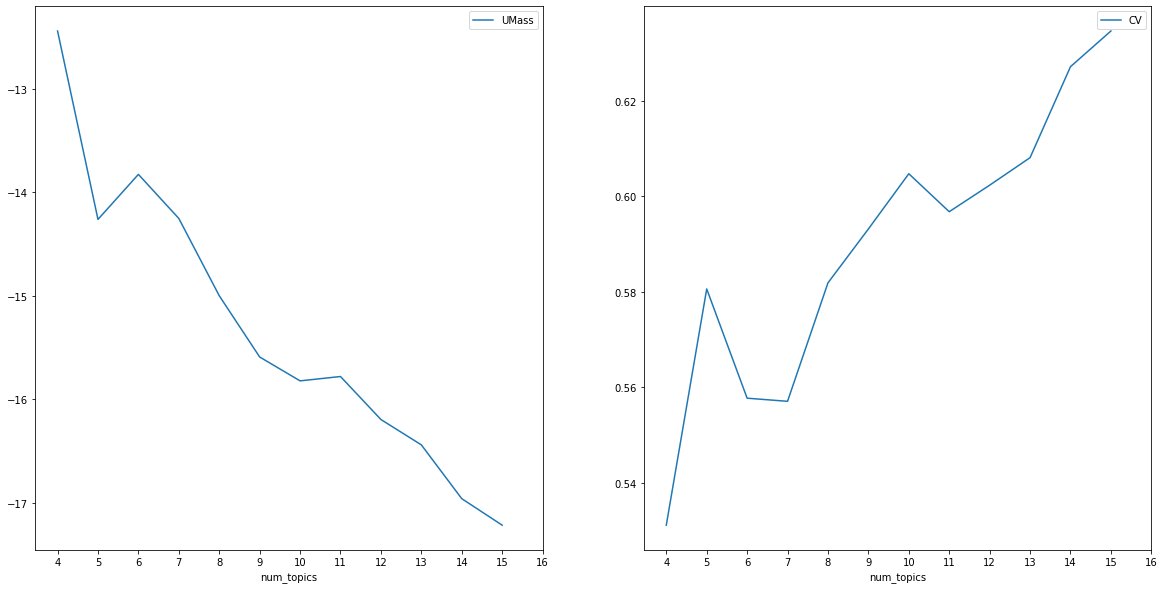

In [123]:
%matplotlib inline
scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(4,17));
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(4,17));

In [125]:
#It takes around 2 minutes
n_topics_author = 10            #I take 10 because it is a local maximum for CV and I think it is enough!

#I find chunksize to make about 200 updates
num_passes = 10
chunk_size = len(model_corpus) * num_passes/200
print(chunk_size)

author_model = AuthorTopicModel(corpus=list(ldacorpus), author2doc=author2doc, id2word=dictionary, num_topics=n_topics_author,
                                passes=num_passes, chunksize=chunk_size, alpha=0.6, random_state=42)
                                #parameter consistency

2183.4


In [127]:
topic_sep = re.compile("0\.[0-9]{3}\*") #Getting rid of useless formatting

author_model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                author_model.print_topics(num_topics=n_topics_author, num_words=5)]


author_descriptors = []
for i, m in sorted(author_model_topics):
    print(i+1, ", ".join(m[:5]))
    author_descriptors.append(", ".join(m[:2]).replace('"', ''))

1 "thank", "read", "make", "never", "become"
2 "religion", "thing", "small", "person", "think"
3 "error", "take", "risk", "great", "mistake"
4 "problem", "call", "event", "year", "course"
5 "world", "business", "history", "theory", "give"
6 "chapter", "cause", "look", "economic", "believe"
7 "point", "understand", "where", "show", "company"
8 "other", "system", "follow", "percent", "fragility"
9 "people", "science", "effect", "write", "first"
10 "large", "benefit", "consider", "well", "mean"


In [128]:
author_vecs = {author: {author_descriptors[t]: 0.0
                         for t in range(author_model.num_topics)}
              for author in author_model.id2author.values()}

for author in author_model.id2author.values():
    for (t, v) in author_model.get_author_topics(author):
        author_vecs[author][author_descriptors[t]] = v

        
target_books = 'Fooled_by_randomness The_Black_Swan The_Bed_of_Procrustes Antifragile_things_that_gain_from_disorder Skin_in_the_game'.split()
for book in target_books:
    print(book, author_vecs[book])
    
#Quite interesting results, aren't they?

Fooled_by_randomness {'thank, read': 0.046354953508469715, 'religion, thing': 0.01645728216298673, 'error, take': 0.04604025733311344, 'problem, call': 0.20721063219979627, 'world, business': 0.22913380541748218, 'chapter, cause': 0.15121173734562104, 'point, understand': 0.0, 'other, system': 0.20693471931799268, 'people, science': 0.0, 'large, benefit': 0.09393879897104832}
The_Black_Swan {'thank, read': 0.16702229884835532, 'religion, thing': 0.20359090105410532, 'error, take': 0.07315949190226828, 'problem, call': 0.22437723346756247, 'world, business': 0.06692427865919716, 'chapter, cause': 0.05890763071491949, 'point, understand': 0.09200145300616368, 'other, system': 0.0, 'people, science': 0.03451047423497999, 'large, benefit': 0.07617581381813648}
The_Bed_of_Procrustes {'thank, read': 0.042134105737161094, 'religion, thing': 0.09465275302916382, 'error, take': 0.0, 'problem, call': 0.27697934293060517, 'world, business': 0.0, 'chapter, cause': 0.14564419405591492, 'point, unde

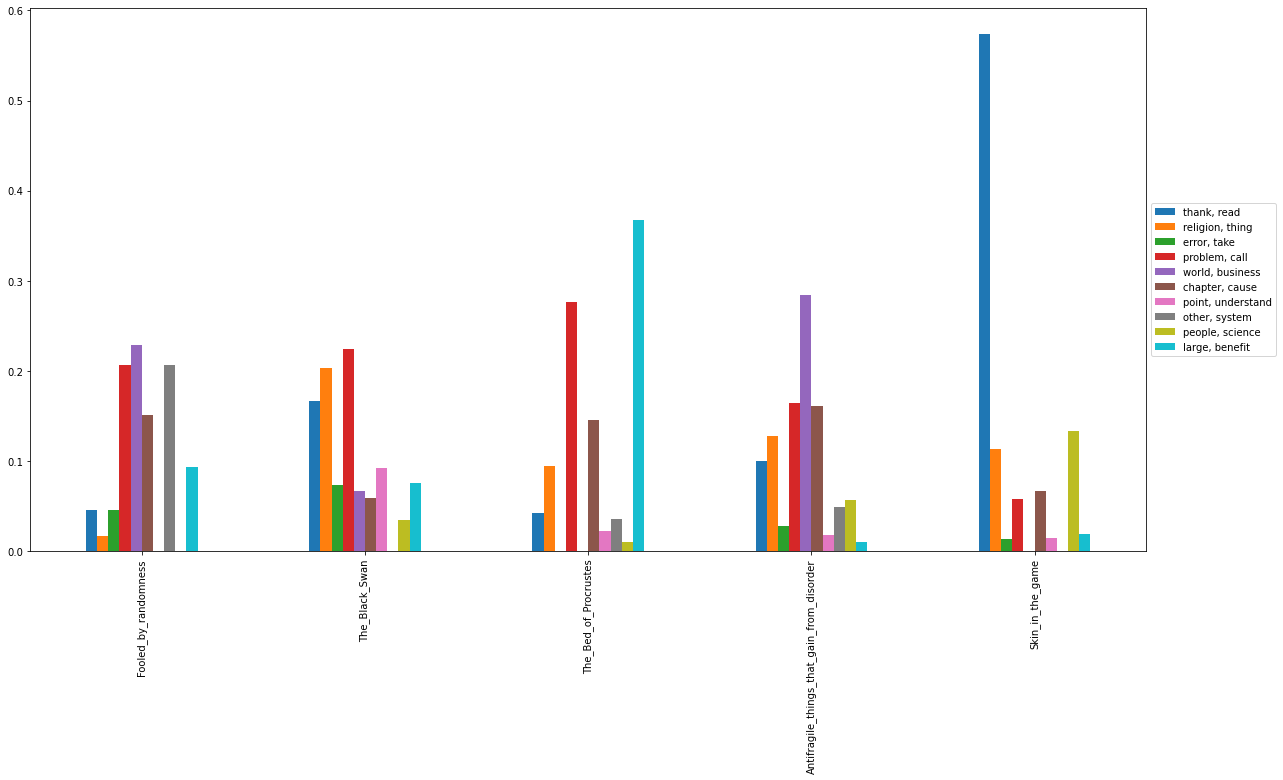

In [129]:
#Author topic model graphically

author_df = pd.DataFrame.from_dict(author_vecs)

fig, ax = plt.subplots(figsize=(20,10))
author_df[target_books].T.plot.bar(ax=ax)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

Also for this graph I think it worth spending some words. 


First of all, I would say that this **author topic model** surprised me a lot. Given the fact I read the books and I got the general feeling about them, I really expected that in any dimension would make much sense to try to distinguish between topics within Taleb's books. \
It turns out that my priors were completely biased and some relevant differences must be underlined.


One distinction that immediately captured my attention is the one between 'religion' (orange bars) and 'science' (light green bars). In fact, except for Taleb's last book ('Skin in the game'), where he elaborates on all his studies, these two attributes appear to be completely distinct. Where one appears, the other almost never does. \
Moreover, I think that the blue bar appearing in 'Skin in the game' is mostly driven by the attribute 'never'. In fact, even if it appears to be a widely used word, I don't remember its intensive employment in the author's books. Typically, Taleb does not handle such 'strong' word; he prefers a more in-between vocabulary. \
Then, also the light blue bar of 'The bed of Procrustes' appears to be meaningful. However, I have no suggested explanation for this one. \
Finally, note how the red bar, probably driven by 'problem', is widely present in all the books except for the last one. Maybe the author has solved some of the problems which characterized his vocabulary in the previous publications along the way. It would be interesting to ask this directly to him.


Definitely, I think the meaning provided by this graphical representation may be very relevant and it further investigation may be worthy.

## **Matrix Factorization, SVD and Latent topics**

In [130]:
#Matrix Factorization of unigrams and bigrams:

tfidf_vectorizer_mf = TfidfVectorizer(ngram_range=(1,2), stop_words='english', analyzer='word', 
                                      min_df=0.0001, max_df=0.4, sublinear_tf=True, use_idf=True)

X = tfidf_vectorizer_mf.fit_transform(documents)

In [131]:
#SVD

k = 35  #Number of latent components

svd = TruncatedSVD(n_components=k)
%time U = svd.fit_transform(X)
S = svd.singular_values_
V = svd.components_

Wall time: 443 ms


In [132]:
#Latent Topics
#We can use the term views V (from SVD) to describe the latent concept dimensions.

def show_topics(A, vocabulary, topn=3):
    
#find the top 3 words for each of the latent dimensions (=rows) in a matrix
  
    topic_words = ([[vocabulary[i] for i in np.argsort(t)[:-topn-1:-1]] for t in A])
    return [', '.join(t) for t in topic_words]


In [134]:
terms = tfidf_vectorizer_mf.get_feature_names()

show_topics(V, terms)

['people, just, like',
 'black, swan, black swan',
 'people, black, swan',
 'just, predict, just predict',
 'time, just, predict',
 'life, just, real',
 'game, skin, skin game',
 'like, game, skin',
 'game, life, know',
 'randomness, things, world',
 'book, randomness, just',
 'chapter, randomness, know',
 'problem, randomness, know',
 'things, book, knowledge',
 'did, point, work',
 'things, did, new',
 'knowledge, did, new',
 'world, way, real',
 'way, make, did',
 'called, small, effect',
 'small, large, number',
 'war, way, swans',
 'events, history, swans',
 'does, say, swans',
 'risk, point, swans',
 'events, information, point',
 'history, idea, science',
 'idea, need, good',
 'risk, say, science',
 'say, information, work',
 'does, good, tony',
 'history, information, tony',
 'information, probability, effect',
 'antifragility, fragility, right',
 'say, idea, antifragility']

In [135]:
sb.set_context('notebook')

def plot_vectors(vectors, title='KM tridimensional representation', labels=None, dimensions=3):
    
    fig = plt.figure(figsize=(10,10))

    df_books = pd.DataFrame(data={'x':vectors[:,0], 'y': vectors[:,1]})
    if labels is not None:
        df_books['label'] = labels
    else:
        df_books['label'] = [''] * len(df_books)
    
    #Colouring labels
    cm = plt.get_cmap('plasma') 
    n_labels = len(df_books.label.unique())
    label_colors = [cm(1. * i/n_labels) for i in range(n_labels)]
    cMap = colors.ListedColormap(label_colors)
        
    #Plot in 3 dimensions
    if dimensions == 3:
        df_books['z'] = vectors[:,2]
        
        ax = fig.add_subplot(111, projection='3d')
        frame1 = plt.gca() 
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        frame1.axes.zaxis.set_ticklabels([])

        for l, label in enumerate(df_books.label.unique()):
            df_books2 = df_books[df_books.label == label]
            color_values = [label_colors[l]] * len(df_books2)
            ax.scatter(df_books2['x'], df_books2['y'], df_books2['z'], c=color_values, 
                       cmap=cMap, edgecolor='black', label=label, alpha=0.4, s=100)
      
    #Plot in 2 dimensions
    elif dimensions == 2:
        ax = fig.add_subplot(111)
        frame1 = plt.gca() 
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])

        for l, label in enumerate(df_books.label.unique()):
            df_books2 = df_books[df_books.label == label]
            color_values = [label_colors[l]] * len(df_books2)
            ax.scatter(df_books2['x'], df_books2['y'], c=color_values, cmap=cMap, 
                       edgecolor='black', label=label, alpha=0.4, s=100)

    else:
        raise NotImplementedError()

    plt.title(title)
    plt.show()

In [136]:
low_dim_svd = TruncatedSVD(n_components=3)

#Let's visualize 1 document every 5, so to pass through all the books proportionally.
Z = X[:-1:5]
b_categories = df_books.Book[:-1:5]

low_dim_U = low_dim_svd.fit_transform(Z)

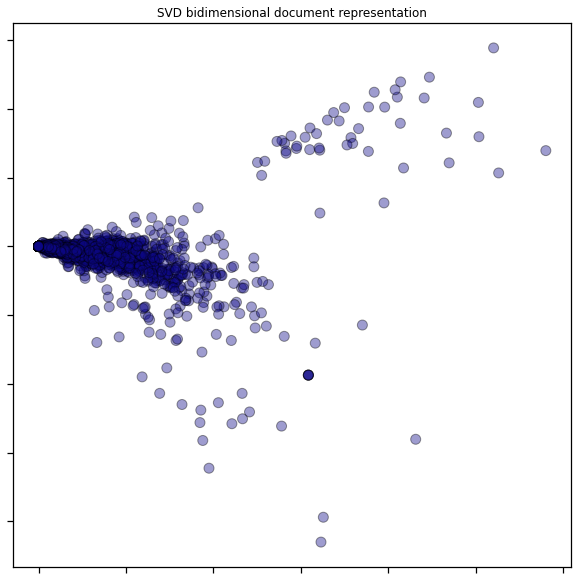

In [137]:
plot_vectors(low_dim_U, title='SVD bidimensional document representation', labels=b_categories, dimensions=2) 
#Documents represented in 2 dimensions

#Apparently, there is the tendency of documents of overlapping for the majority. Still, we see some distinction in the rightern part.

## **CLUSTERS**

**Evaluating Clusters**

To choose the best number of clusters, we can fit various models with different numbers of components and observe the resulting **silhouette score**. But before taking the score, I try a random k and then train some models. At the end, you find the silhouette score code that I employed in order to end up with the k=9 I use.

In [146]:
k = 9 #silouette score

%time X2 = TruncatedSVD(n_components=65).fit_transform(X)  #default number of components because useful for visualization.

agg = AgglomerativeClustering(n_clusters=k)

Wall time: 751 ms


In [147]:
sample = np.random.choice(len(X2), replace=False, size=12000)
%time agg_sample_ids = agg.fit_predict(X2[sample])

centroids = np.array([X2[sample][agg_sample_ids == c].mean(axis=0) for c in range(k)])

Wall time: 11 s


In [149]:
km = KMeans(n_clusters=k, init=centroids, 
            n_init=100,
            max_iter=900, #result of some trials
            tol=0.000001, #very small number is suggested
            random_state=None,
            copy_x=True,
            algorithm='full') #EM algorithm

%time km.fit(X2)

Wall time: 92.2 ms


<timed eval>:1: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=100


KMeans(algorithm='full',
       init=array([[ 2.82074720e-02,  1.89279034e-03, -1.50512283e-02,
        -3.02515092e-04, -1.47530597e-03, -2.92192480e-03,
        -2.39614492e-03,  6.94798293e-04, -7.30121502e-03,
        -1.06878623e-03, -2.93527831e-03, -4.93390694e-03,
        -8.53520504e-04, -1.00221860e-03, -3.82439634e-03,
        -1.60026239e-03, -6.49168036e-03, -1.72169134e-03,
        -1.19598312e-03, -2.26389504e...
         7.20896533e-04, -2.38528014e-03, -2.72490665e-03,
        -2.47244120e-03, -2.89194786e-03, -3.94843479e-04,
         1.00316121e-02,  7.59363530e-03, -4.20934451e-03,
         1.32943565e-03,  7.18354960e-03,  6.71115402e-03,
         2.93406254e-04,  1.38664917e-03,  5.13038345e-03,
         1.47239112e-03, -1.90288830e-03, -1.19895637e-03,
         2.68715529e-03, -3.71773633e-03]]),
       max_iter=900, n_clusters=9, n_init=100, tol=1e-06)

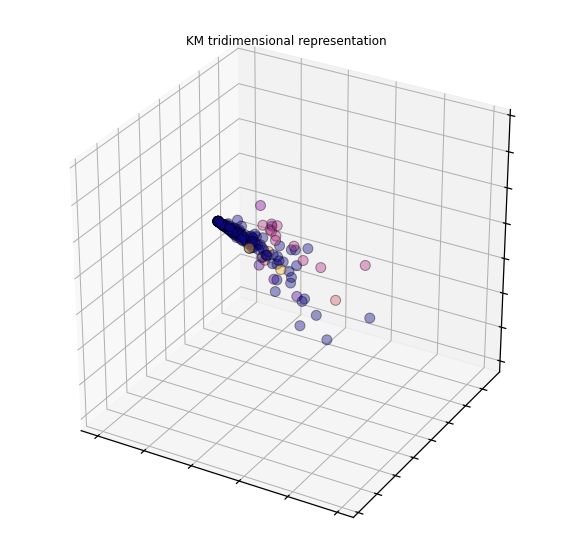

In [150]:
#We can now plot data into 3 dimensions:

plot_sample = np.random.choice(len(X2), replace=False, size=180)
plot_vectors(X2[plot_sample], labels=km.labels_[plot_sample])

#However, nothing very interesting shows up. Data overlap too much.

8 0.3333933290155297
9 0.33736113969956577
10 0.2691984195447922
11 0.28042491256249463
12 0.28731943408216415
13 0.29104479467081584
14 0.29660426038576515
15 0.30106567125493827
16 0.30629487944313605
17 0.31422807605229197


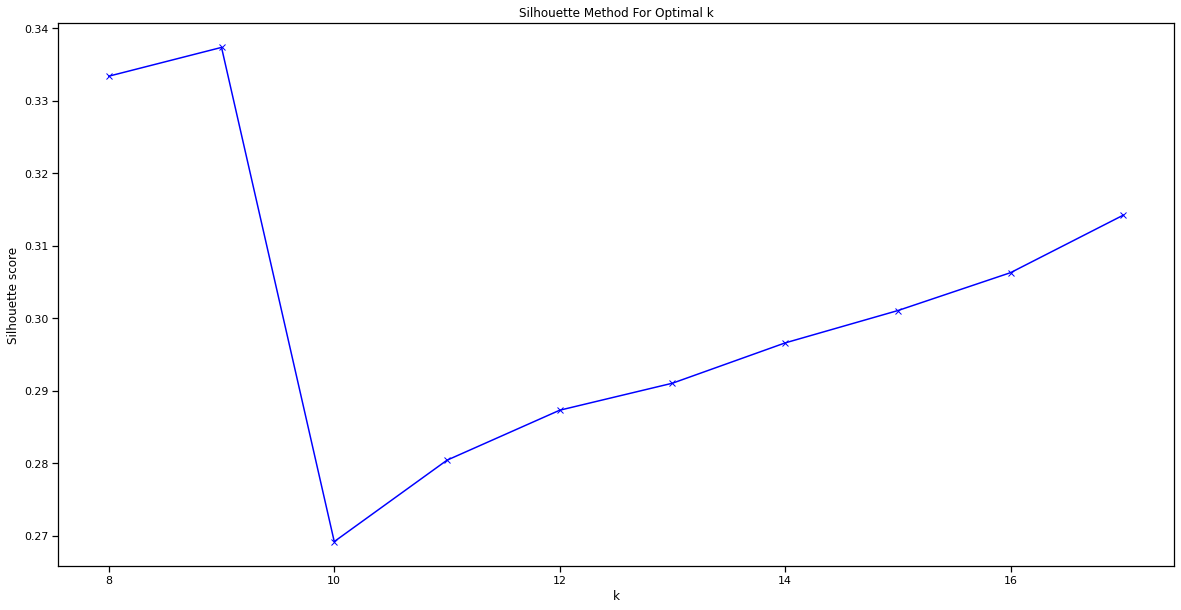

In [145]:
#SILHOUETTE SCORE

silhouettes = []

K = range(8, 18)    #With higher ranges we even increase a bit the silhouette score. Nevertheless, I think this range is enough.

for c in K:
    agg_clustering = AgglomerativeClustering(n_clusters=c)

    agg_cluster_ids = agg_clustering.fit_predict(X2[sample])
    score = silhouette_score(X2[sample], agg_cluster_ids)
    silhouettes.append(score)
    print(c, score)
    
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method For Optimal k')
plt.show()

**Final comment:**

I really enjoyed this deepening of Taleb's knowledge because he is the most significant author I ever faced in my life and thus any extra-information I can retrieve about his style is valuable. \
I hope you have enjoyed it too.


Thank you.